In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from utils import plot_confusion_matrix, plot_confusion_matrix, get_gzipped_model_size
from data_organizer_Kfall import DataOrganizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
from keras import models, optimizers, callbacks
from keras.utils import to_categorical
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from models.ConvLSTM import ConvLSTM
from models.ConvLSTM_VGG import ConvLSTM_VGG
from models.TinyFallNet import TinyFallNet
from models.ResNet24 import ResNet24

2023-12-10 23:17:42.398687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 23:17:42.398754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 23:17:42.400991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 23:17:42.417963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 23:17:43.291165: W tensorflow/compiler/tf2

# Model Config

In [2]:
model_name = "ResNet24" # "ConvLSTM" or "ConvLSTM_VGG" or "TinyFallNet" or "ResNet24"
load_from_checkpoint = False

if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

if load_from_checkpoint:
    model = models.load_model('./saved_models/'+model_name+'.keras')
else:
    if model_name == "ConvLSTM":
        model = ConvLSTM()
    elif model_name == "ConvLSTM_VGG":
        
        model = ConvLSTM_VGG()
    elif model_name == "TinyFallNet":
        
        model = TinyFallNet()
    elif model_name == "ResNet24":
        
        model = ResNet24()
    else:
        print("Please select a valid model name")
    

2023-12-10 23:17:44.193266: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 23:17:44.238487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 23:17:44.238564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 23:17:44.242110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 23:17:44.242195: I external/local_xla/xla/stream_executor

# Data Loader

In [3]:
# mac
# sensor_data_folder = '/Users/liuxinqing/Documents/Kfall/sensor_data'  # Update with the path to sensor data
# label_data_folder = '/Users/liuxinqing/Documents/Kfall/label_data'  
# windows 
#sensor_data_folder = 'G:\MLonMCU\Kfall_dataset\sensor_data'  # Update with the path to sensor data
#label_data_folder = 'G:\MLonMCU\Kfall_dataset\label_data' 
# linux
sensor_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/sensor_data'  # Update with the path to sensor data
label_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/label_data'  

#window_size = 256
# Kfall: window_size = 50
window_size = 50
threshold = 0.4
num_window_fall_data = 50
num_window_not_fall_data = 5

data, label = DataOrganizer(sensor_data_folder, 
                            label_data_folder, 
                            window_size, 
                            threshold, 
                            num_window_fall_data, 
                            num_window_not_fall_data)

in_channels = 9
print('in_channels: ', in_channels)
# the input data should have the shape (batch_size, in_channels, sequence_length)
#data = data.reshape(data.shape[0], in_channels, -1)
print('data.shape: ', data.shape)

label = label.astype(np.int64)
# one-hot encoding
#label = to_categorical(label, num_classes=2)
# transpose the data to (batch_size, sequence_length, in_channels)
#data = np.transpose(data, (0, 2, 1))
data = data.reshape(data.shape[0], 50, 9)
# normalize the data
# Initialize a new scaling object for normalizing input data
# Z-score normalization

# (y == 0).sum()
B_size = (label == 0).sum()
A_size = (label == 1).sum()
print('B_size: ', B_size)	
print('A_size: ', A_size)
# transpose the data to (batch_size, in_channels, sequence_length)
#data = np.transpose(data, (0, 2, 1))
print('data: ', data[0][0])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print(np.unique(y_train)) # [0 1]
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

# select the test data that is not zero
X_test_true = X_test[y_test != 0]
y_test_true = y_test[y_test != 0]
# length of the test data
test_len = X_test_true.shape[0]
X_test_false = X_test[y_test == 0]
y_test_false = y_test[y_test == 0]
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
index = np.random.choice(X_test_false.shape[0], test_len, replace=False)
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
#index = np.random.choice(X_test_false.shape[0], len, replace=False)

X_test_false = X_test[index]
y_test_false = y_test[index]

# concatenate the true and false test data
X_test = np.concatenate((X_test_true, X_test_false), axis=0)
y_test = np.concatenate((y_test_true, y_test_false), axis=0)
#X_test = X_test[y_test != 0]
#y_test = y_test[y_test != 0]
print(X_test.shape)

Processing 1/32 folder...
Processing 2/32 folder...
Processing 3/32 folder...
Processing 4/32 folder...
Processing 5/32 folder...
Processing 6/32 folder...
Processing 7/32 folder...
Processing 8/32 folder...
Processing 9/32 folder...
Processing 10/32 folder...
Processing 11/32 folder...
Processing 12/32 folder...
Processing 13/32 folder...
Processing 14/32 folder...
Processing 15/32 folder...
Processing 16/32 folder...
Processing 17/32 folder...
Processing 18/32 folder...
Processing 19/32 folder...
Processing 20/32 folder...
Processing 21/32 folder...
Processing 22/32 folder...
Processing 23/32 folder...
Processing 24/32 folder...
Processing 25/32 folder...
Processing 26/32 folder...
Processing 27/32 folder...
Processing 28/32 folder...
Processing 29/32 folder...
Processing 30/32 folder...
Processing 31/32 folder...
Processing 32/32 folder...
in_channels:  9
data.shape:  (25619, 50, 9)
B_size:  25020
A_size:  599
data:  [ 5.60000000e-02 -9.96000000e-01 -2.50000000e-02  2.23453620e+00
 

# Hyperparameters

In [4]:
# Hyperparameters
learning_rate = 5e-4
batch_size = 64
epochs = 50
factor = 0.5
patience = 5

# Model Training

In [5]:
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), 
            loss='categorical_crossentropy',
            #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
model.build(input_shape=(None, 50, 9))
model.summary()


Model: "ResNet24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 50, 9)             0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 1, 48, 64)            1792      ['reshape[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1, 46, 64)            12352     ['conv2d[0][0]']              
                                                                                           

 conv2d_14 (Conv2D)          (None, 1, 23, 16)            1040      ['re_lu_8[0][0]']             
                                                                                                  
 batch_normalization_9 (Bat  (None, 1, 23, 16)            64        ['conv2d_14[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 re_lu_9 (ReLU)              (None, 1, 23, 16)            0         ['batch_normalization_9[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_15 (Conv2D)          (None, 1, 23, 16)            784       ['re_lu_9[0][0]']             
                                                                                                  
 batch_nor

In [6]:
""" train(train_dataloader, model_ConvLSTM, loss_fn, optimizer,val_dataloader, 
           patience=patience, scheduler=scheduler, epochs=epochs, device=device, B_size=B_size, A_size=A_size) """
# Train the model
# Train the model without using batches
# Compile the model
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

# Calculate class weights
B_multiplier = 1
A_multiplier = B_size / A_size
class_weight = {0: B_multiplier, 1: A_multiplier}

# Ensure y_train and y_val are one-hot encoded only once
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
lrs = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
print('X_train.shape: ', X_train.shape) # (23291, 50, 9)
print('y_train.shape: ', y_train.shape) # (23291,)

history = model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[es, lrs],
          class_weight=class_weight) 

y_train.shape:  (16396, 2)
y_val.shape:  (4099, 2)
X_train.shape:  (16396, 50, 9)
y_train.shape:  (16396, 2)


Epoch 1/50


2023-12-10 23:18:18.483368: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-10 23:18:19.506261: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-10 23:18:19.506991: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-10 23:18:19.537113: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-10 23:18:19.537176: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:110] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-12-10 23:18:19.567149: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-10 23:18:19.567304: W external/local_xla/xla/stream

257/257 [==============================] - 25s 40ms/step - loss: 1.5714 - accuracy: 0.7790 - val_loss: 0.5211 - val_accuracy: 0.8446 - lr: 5.0000e-04
Epoch 2/50
257/257 [==============================] - 8s 32ms/step - loss: 0.7549 - accuracy: 0.8738 - val_loss: 0.3272 - val_accuracy: 0.9051 - lr: 5.0000e-04
Epoch 3/50
257/257 [==============================] - 8s 31ms/step - loss: 0.6874 - accuracy: 0.8708 - val_loss: 0.2826 - val_accuracy: 0.9168 - lr: 5.0000e-04
Epoch 4/50
257/257 [==============================] - 8s 31ms/step - loss: 0.6422 - accuracy: 0.8874 - val_loss: 0.2748 - val_accuracy: 0.9219 - lr: 5.0000e-04
Epoch 5/50
257/257 [==============================] - 8s 31ms/step - loss: 0.5944 - accuracy: 0.8967 - val_loss: 0.4528 - val_accuracy: 0.8668 - lr: 5.0000e-04
Epoch 6/50
257/257 [==============================] - 8s 32ms/step - loss: 0.5224 - accuracy: 0.9040 - val_loss: 0.5043 - val_accuracy: 0.8383 - lr: 5.0000e-04
Epoch 7/50
257/257 [==============================

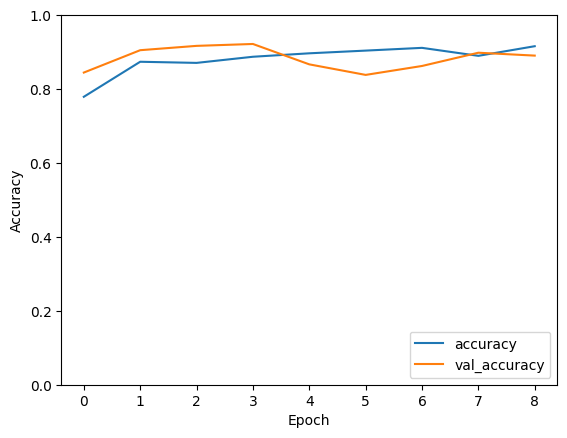

In [7]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Model Evaluation

In [8]:
# Evaluate the model
print('X_test.shape: ', X_test.shape)
if y_test.ndim == 1:
    y_test = to_categorical(y_test)
test_loss = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)

X_test.shape:  (248, 50, 9)


8/8 - 1s - loss: 0.1883 - accuracy: 0.9435 - 783ms/epoch - 98ms/step
Test loss: [0.18829847872257233, 0.9435483813285828]


8/8 [==============================] - 0s 6ms/step
[[111  10]
 [  4 123]]
Confusion matrix, without normalization
[[111  10]
 [  4 123]]
accuracy:  0.9435483870967742
f1_score:  0.9461538461538462


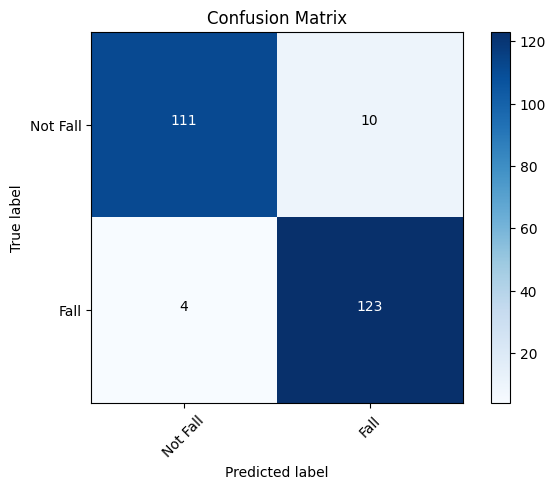

In [9]:
# Convert y_test back to its original form
y_test_original = np.argmax(y_test, axis=-1)

# Get the model's predictions
predictions = np.argmax(model.predict(X_test), axis=-1)


# Compute the confusion matrix
cm = confusion_matrix(y_test_original, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
print('accuracy: ', accuracy_fp)
# f1 score
precision_fp = cm[1][1] / (cm[1][1] + cm[0][1])
recall_fp = cm[1][1] / (cm[1][1] + cm[1][0])
f1_score_fp = 2 * precision_fp * recall_fp / (precision_fp + recall_fp)
print('f1_score: ', f1_score_fp)


# Save Model

In [10]:
model.save('./saved_models/'+model_name+'.keras')
# convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
if model_name=="ConvLSTM" or model_name=="ConvLSTM_VGG":
    converter._experimental_lower_tensor_list_ops = False
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
model_tflite = converter.convert()
# save the model
open('./saved_models/'+model_name+'.tflite', "wb").write(model_tflite)


INFO:tensorflow:Assets written to: /tmp/tmpuhvu1npd/assets


INFO:tensorflow:Assets written to: /tmp/tmpuhvu1npd/assets
2023-12-10 23:19:51.699725: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-10 23:19:51.699772: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-10 23:19:51.700162: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpuhvu1npd
2023-12-10 23:19:51.712930: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-10 23:19:51.712956: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpuhvu1npd
2023-12-10 23:19:51.735387: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-10 23:19:51.752252: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-10 23:19:52.139836: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

231716

# Quantization

In [ ]:
# only for ConvLSTM model
if model_name=="ConvLSTM" or model_name=="ConvLSTM_VGG":
    def representative_data_gen():
        for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
            yield [input_value]

    converter = tf.lite.TFLiteConverter.from_keras_model(ConvLSTM)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.float32
    converter.inference_output_type = tf.int8

    tflite_q_model = converter.convert()
    interpreter = tf.lite.Interpreter(model_content=tflite_q_model)
    input_type = interpreter.get_input_details()[0]['dtype']
    print('input: ', input_type)
    output_type = interpreter.get_output_details()[0]['dtype']
    print('output: ', output_type)
    # Save the quantized model to disk
    open('./saved_models/'+model_name+'_q.tflite', "wb").write(tflite_q_model)
    

In [11]:
q_model = tfmot.quantization.keras.quantize_model(model)
q_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

q_model.summary()


Model: "ResNet24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 quantize_layer (QuantizeLa  (None, 50, 9)                3         ['input_1[0][0]']             
 yer)                                                                                             
                                                                                                  
 quant_reshape (QuantizeWra  (None, 1, 50, 9)             1         ['quantize_layer[0][0]']      
 pperV2)                                                                                          
                                                                                           

In [12]:
q_model.save('./saved_models/'+model_name+'_q.keras')
# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

# Set up the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(q_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# This is required for full integer quantization (including input and output)
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32  # Keep input as float32
converter.inference_output_type = tf.int8  # Keep output as float32

# Convert the model
tflite_q_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_q_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open('./saved_models/'+model_name+'_q.tflite', "wb").write(tflite_q_model)


INFO:tensorflow:Assets written to: /tmp/tmp5ikx8m3s/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ikx8m3s/assets
/home/liyinrong/miniconda3/envs/tensorflow-dev/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


input:  <class 'numpy.float32'>
output:  <class 'numpy.int8'>


2023-12-10 23:20:14.852480: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-10 23:20:14.852575: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-10 23:20:14.852958: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5ikx8m3s
2023-12-10 23:20:14.866108: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-10 23:20:14.866137: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp5ikx8m3s
2023-12-10 23:20:14.926252: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-10 23:20:15.353904: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp5ikx8m3s
2023-12-10 23:20:15.507496: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 654541 

108648

# QAT

In [13]:
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

q_history = q_model.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs],
            class_weight=class_weight) 

y_train.shape:  (16396, 2)
y_val.shape:  (4099, 2)
Epoch 1/50
257/257 [==============================] - 47s 137ms/step - loss: 0.9247 - accuracy: 0.7889 - val_loss: 0.1314 - val_accuracy: 0.9617 - lr: 5.0000e-04
Epoch 2/50
257/257 [==============================] - 35s 135ms/step - loss: 0.7832 - accuracy: 0.8409 - val_loss: 0.3740 - val_accuracy: 0.8785 - lr: 5.0000e-04
Epoch 3/50
257/257 [==============================] - 34s 133ms/step - loss: 0.5639 - accuracy: 0.8806 - val_loss: 0.2679 - val_accuracy: 0.9107 - lr: 5.0000e-04
Epoch 4/50
257/257 [==============================] - 32s 126ms/step - loss: 0.5185 - accuracy: 0.8977 - val_loss: 0.2419 - val_accuracy: 0.9173 - lr: 5.0000e-04
Epoch 5/50
257/257 [==============================] - 32s 124ms/step - loss: 0.4648 - accuracy: 0.9058 - val_loss: 0.1931 - val_accuracy: 0.9375 - lr: 5.0000e-04
Epoch 6/50
257/257 [==============================] - ETA: 0s - loss: 0.3772 - accuracy: 0.9194
Epoch 6: ReduceLROnPlateau reducing learnin

In [14]:
q_model.save('./saved_models/'+model_name+'_qat.keras')  # The file needs to end with the .keras extension
# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

# Set up the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(q_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# This is required for full integer quantization (including input and output)
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32  # Keep input as float32
converter.inference_output_type = tf.int8  # Keep output as float32

# Convert the model
tflite_q_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_q_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open('./saved_models/'+model_name+'_qat.tflite', "wb").write(tflite_q_model)


INFO:tensorflow:Assets written to: /tmp/tmpv4u2rj46/assets


INFO:tensorflow:Assets written to: /tmp/tmpv4u2rj46/assets
/home/liyinrong/miniconda3/envs/tensorflow-dev/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-12-10 23:24:05.872217: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-10 23:24:05.872260: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.


input:  <class 'numpy.float32'>
output:  <class 'numpy.int8'>


2023-12-10 23:24:05.872447: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpv4u2rj46
2023-12-10 23:24:05.897592: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-10 23:24:05.897622: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpv4u2rj46
2023-12-10 23:24:05.979963: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-10 23:24:06.696978: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpv4u2rj46
2023-12-10 23:24:06.931430: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 1058984 microseconds.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 6, Total Ops 111, % non-converted = 5.41 %
 * 6 ARITH ops

- arith.constant:    6 occurrences  (i32: 6)



  (uq

108928

# Prune

In [15]:
# Unstrucutred pruning with constant sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=2000, frequency=100),
}

ups = pruning_callbacks.UpdatePruningStep()
# Create a pruning model
pruned_model_unstructured = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model_unstructured.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model_unstructured.summary()


Model: "ResNet24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 prune_low_magnitude_reshap  (None, 1, 50, 9)             1         ['input_1[0][0]']             
 e (PruneLowMagnitude)                                                                            
                                                                                                  
 prune_low_magnitude_conv2d  (None, 1, 48, 64)            3522      ['prune_low_magnitude_reshape[
  (PruneLowMagnitude)                                               0][0]']                       
                                                                                           

In [16]:
pruned_model_unstructured.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs, ups],
            class_weight=class_weight) 

Epoch 1/50
257/257 [==============================] - 36s 68ms/step - loss: 0.5781 - accuracy: 0.8952 - val_loss: 0.5448 - val_accuracy: 0.8148 - lr: 5.0000e-04
Epoch 2/50
257/257 [==============================] - 17s 65ms/step - loss: 0.4927 - accuracy: 0.9028 - val_loss: 0.2778 - val_accuracy: 0.9197 - lr: 5.0000e-04
Epoch 3/50
257/257 [==============================] - 17s 65ms/step - loss: 0.4412 - accuracy: 0.9143 - val_loss: 0.2964 - val_accuracy: 0.8909 - lr: 5.0000e-04
Epoch 4/50
257/257 [==============================] - 16s 64ms/step - loss: 0.4204 - accuracy: 0.9152 - val_loss: 0.2827 - val_accuracy: 0.9136 - lr: 5.0000e-04
Epoch 5/50
257/257 [==============================] - 17s 65ms/step - loss: 0.4729 - accuracy: 0.9024 - val_loss: 0.2702 - val_accuracy: 0.9095 - lr: 5.0000e-04
Epoch 6/50
257/257 [==============================] - 17s 65ms/step - loss: 0.3454 - accuracy: 0.9254 - val_loss: 0.1803 - val_accuracy: 0.9368 - lr: 5.0000e-04
Epoch 7/50
257/257 [==============

In [17]:
# evaluate the model on the test set
pruned_loss_unstructured, pruned_acc_unstructured = pruned_model_unstructured.evaluate(X_test, y_test, verbose=0)
print('Pruned model loss: ', pruned_loss_unstructured)
print('Pruned model accuracy: ', pruned_acc_unstructured)
print('Full-precision model accuracy: ', accuracy_fp)


Pruned model loss:  0.19394589960575104
Pruned model accuracy:  0.9354838728904724
Full-precision model accuracy:  0.9435483870967742


In [18]:
# save the model
pruned_model_unstructured.save('./saved_models/'+model_name+'_pruned_unstructured.keras')  # The file needs to end with the .keras extension
#print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file_unstructured))

# Conversion to TF Lite
pruned_model_unstructured_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model_unstructured)

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_unstructured_for_export)
pruned_tflite_model_unstructured = converter.convert()

# Save the model
pruned_tflite_file_unstructured = './saved_models/'+model_name+'_pruned_unstructured.tflite'

with open(pruned_tflite_file_unstructured, 'wb') as f:
    f.write(pruned_tflite_model_unstructured)

# print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file_unstructured))


INFO:tensorflow:Assets written to: /tmp/tmp7rz2j_ne/assets


INFO:tensorflow:Assets written to: /tmp/tmp7rz2j_ne/assets
2023-12-10 23:31:35.597711: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-10 23:31:35.597755: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-10 23:31:35.598019: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp7rz2j_ne
2023-12-10 23:31:35.609336: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-10 23:31:35.609360: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp7rz2j_ne
2023-12-10 23:31:35.638142: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-10 23:31:35.808204: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp7rz2j_ne
2023-12-10 23:31:35.875383: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [19]:
# compare the size of the pruned model and the full-precision model
print('Size of the unstructured pruned model: ', get_gzipped_model_size('./saved_models/'+model_name+'_pruned_unstructured.tflite'))
print('Size of the full-precision model: ', get_gzipped_model_size('./saved_models/'+model_name+'.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('./saved_models/'+model_name+'.tflite') / get_gzipped_model_size('./saved_models/'+model_name+'_pruned_unstructured.tflite')))


Size of the unstructured pruned model:  127757
Size of the full-precision model:  201952
The achieved compression ratio is 1.58x


# PQAT

In [20]:
# PQAT
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              pruned_model_unstructured_for_export)

pruned_qat_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotate_model,
                   tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())

pruned_qat_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

pruned_qat_model.summary()


Model: "ResNet24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 quantize_layer_1 (Quantize  (None, 50, 9)                3         ['input_1[0][0]']             
 Layer)                                                                                           
                                                                                                  
 quant_reshape (QuantizeWra  (None, 1, 50, 9)             1         ['quantize_layer_1[0][0]']    
 pperV2)                                                                                          
                                                                                           

In [21]:
print('X_train.shape: ', X_train.shape) # (16362, 50, 9)
print('y_train.shape: ', y_train.shape) # (16362, 2)
print(batch_size)
pruned_qat_model.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs],
            class_weight=class_weight) 


X_train.shape:  (16396, 50, 9)
y_train.shape:  (16396, 2)
64


Epoch 1/50
257/257 [==============================] - 43s 128ms/step - loss: 1.2473 - accuracy: 0.7596 - val_loss: 0.2433 - val_accuracy: 0.9080 - lr: 5.0000e-04
Epoch 2/50
257/257 [==============================] - 32s 124ms/step - loss: 0.6699 - accuracy: 0.8447 - val_loss: 0.3022 - val_accuracy: 0.8766 - lr: 5.0000e-04
Epoch 3/50
257/257 [==============================] - 32s 124ms/step - loss: 0.4701 - accuracy: 0.8922 - val_loss: 0.3014 - val_accuracy: 0.8949 - lr: 5.0000e-04
Epoch 4/50
257/257 [==============================] - 32s 126ms/step - loss: 0.3617 - accuracy: 0.9168 - val_loss: 0.2725 - val_accuracy: 0.9063 - lr: 5.0000e-04
Epoch 5/50
257/257 [==============================] - 32s 126ms/step - loss: 0.2603 - accuracy: 0.9409 - val_loss: 0.2222 - val_accuracy: 0.9266 - lr: 5.0000e-04
Epoch 6/50
257/257 [==============================] - 32s 124ms/step - loss: 0.2172 - accuracy: 0.9525 - val_loss: 0.1652 - val_accuracy: 0.9471 - lr: 5.0000e-04
Epoch 7/50
257/257 [========

In [22]:
# evaluate the model on the test set
pruned_qat_loss, pruned_qat_acc = pruned_qat_model.evaluate(X_test, y_test, verbose=0)
print('Pruned QAT model loss: ', pruned_qat_loss)
print('Pruned QAT model accuracy: ', pruned_qat_acc)
print('Full-precision model accuracy: ', accuracy_fp)


Pruned QAT model loss:  0.2202487736940384
Pruned QAT model accuracy:  0.9354838728904724
Full-precision model accuracy:  0.9435483870967742


In [23]:
pruned_qat_model.save('./saved_models/'+model_name+'_pqat.keras')  # The file needs to end with the .keras extension
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_qat_tflite_model = converter.convert()

# Save the model
open('./saved_models/'+model_name+'_pqat.tflite', "wb").write(pruned_qat_tflite_model)

# write TFLite model to a C source (or header) file
#c_model_name = 'pruned_qat_fmnist'

#with open('cfiles/' + c_model_name + '.h', 'w') as file:
#    file.write(hex_to_c_array(pruned_qat_tflite_model, c_model_name))


INFO:tensorflow:Assets written to: /tmp/tmpxjgiwyag/assets


INFO:tensorflow:Assets written to: /tmp/tmpxjgiwyag/assets
/home/liyinrong/miniconda3/envs/tensorflow-dev/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-12-10 23:39:06.869146: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-10 23:39:06.869218: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-10 23:39:06.869485: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxjgiwyag
2023-12-10 23:39:06.888448: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-10 23:39:06.888470: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxjgiwyag
2023-12-10 23:39:06.958542: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bun

109104

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


input:  {'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 50,  9], dtype=int32), 'shape_signature': array([-1, 50,  9], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output:  {'name': 'StatefulPartitionedCall:0', 'index': 108, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Evaluated on  0 .
Evaluated on  100 .
Evaluated on  200 .
[[117   4]
 [ 12 115]]
Confusion matrix, without normalization
[[117   4]
 [ 12 115]]
f1_score:  0.9349593495934959


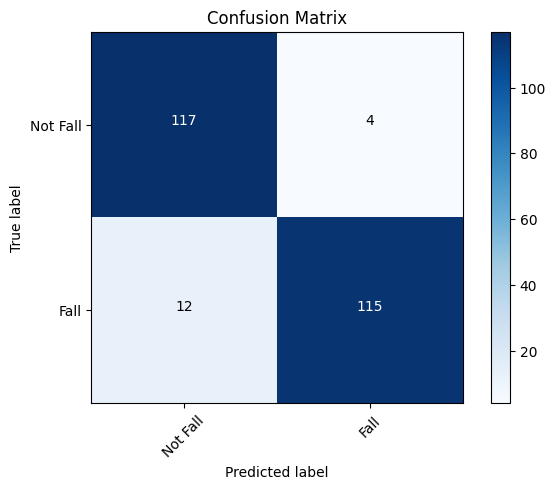

In [24]:
# test the quantized model
X_test_int8 = X_test.astype('float32')
y_test_int8 = y_test.astype('int8')
# Load the model into an interpreter
interpreter = tf.lite.Interpreter(model_content= pruned_qat_tflite_model)
# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_int8):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

gt = np.argmax(y_test_int8, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(gt, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
#accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
#print('accuracy: ', accuracy_fp)

f1_score = 2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0])
print('f1_score: ', f1_score)


In [25]:
# compare the size of the pruned model and the full-precision model
print('Size of the pruned QAT model: ', get_gzipped_model_size('./saved_models/'+model_name+'_pqat.tflite'))
print('Size of th QAT model: ', get_gzipped_model_size('./saved_models/'+model_name+'_qat.tflite'))
print('Size of the full-precision model: ', get_gzipped_model_size('./saved_models/'+model_name+'.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('saved_models/TinyFallNet.tflite') / get_gzipped_model_size('./saved_models/'+model_name+'_pqat.tflite')))


Size of the pruned QAT model:  53273
Size of th QAT model:  69771
Size of the full-precision model:  201952
The achieved compression ratio is 2.30x
